# Training Regression Model

This script reads the files generated by "5_Generate_Regression_Datasets.ipynb" and trains the Regression model in charge of localizing the number strings.

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
from six.moves import cPickle as pickle

## Load Validation and Test sets

In [2]:
#file_name = 'SVHN_data/Regression_3Ch.pickle'
file_name = 'SVHN_data/Regression_3Ch_Test.pickle'

with open(file_name, 'rb') as f:
    save = pickle.load(f)
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save

valid_dataset = valid_dataset[:2000]
valid_labels = valid_labels[:2000]
test_dataset = test_dataset[:2000]
test_labels = test_labels[:2000]

print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(2000, 48, 64, 3) (2000, 5)
(2000, 48, 64, 3) (2000, 5)


## Defining the functions which will load the Training dataset from binary files

In [3]:
def read_binary(filename_queue):
    label_bytes = 5
    img_height = 48
    img_width = 64
    img_channels = 3
    image_bytes = img_height * img_width * img_channels
    
    # Every record consists of a label followed by the image, with a fixed number of bytes for each.
    record_bytes = label_bytes + image_bytes
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    key, value = reader.read(filename_queue)
    record_bytes = tf.decode_raw(value, tf.int8)

    label = tf.cast(tf.slice(record_bytes, [0], [label_bytes]),tf.int32)
    image = tf.cast(tf.reshape(tf.slice(record_bytes, [label_bytes], [image_bytes]),[img_height, img_width, img_channels]), tf.float32)
       
    # Subtract mean
    image = tf.image.per_image_whitening(image)

    return image, label 

def input_pipeline(filenames, batch_size, num_epochs=None):
    num_preprocess_threads = 2
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=num_epochs, shuffle=True)
    
    example_list = [read_binary(filename_queue) for _ in range(num_preprocess_threads)]

    label, image = read_binary(filename_queue)
    min_after_dequeue = 10000
    capacity = min_after_dequeue + 3 * batch_size
    
    image_batch, label_batch = tf.train.shuffle_batch_join(
        example_list, batch_size=batch_size, capacity=capacity,
        min_after_dequeue=min_after_dequeue)

    return image_batch, label_batch

### Define Accuracy

Accuracy is defined in two different ways: the classification accuracy with which the model recognizes whether or not there is a number in the image, and the Dice's similarity coefficent which determines how similar the predicted/real bounding boxes are.

In [4]:
def get_accuracy(predictions, labels, thr):
    temp = predictions[:,1]
    temp[temp>=thr] = 1.0
    temp[temp<thr] = 0.0
    acc = 100.0 * np.sum(temp == labels[:,0]) / predictions.shape[0]
    
    bbox_pred = predictions[predictions[:,1]>=thr,2:]
    bbox_truth = labels[predictions[:,1]>=thr,1:]
    
    # Get overlapping area
    # Coordinates of predicted bbox
    x11 = np.float32(bbox_pred[:,1])
    x12 = np.float32(bbox_pred[:,3])
    y11 = np.float32(bbox_pred[:,0])
    y12 = np.float32(bbox_pred[:,2])
    # Coordinates of g-truth bbox
    x21 = np.float32(bbox_truth[:,1])
    x22 = np.float32(bbox_truth[:,3])
    y21 = np.float32(bbox_truth[:,0])
    y22 = np.float32(bbox_truth[:,2])
    
    x_overlap = np.maximum(0,np.minimum(x12,x22)-np.maximum(x11,x21))
    y_overlap = np.maximum(0,np.minimum(y12,y22)-np.maximum(y11,y21))
    
    areas_pred = np.multiply(x12-x11,y12-y11)
    areas_truth = np.multiply(x22-x21,y22-y21)
    
    overlap_area = np.multiply(x_overlap,y_overlap)
    
    # Dice's similarity coefficient
    Qs = np.divide(2*overlap_area,areas_pred+areas_truth)
    return [acc, np.mean(Qs)]

## Define model

In [6]:
INPUT_WIDTH = 64
INPUT_HEIGHT = 48
NUM_CHANNELS = 3 # Color images

num_labels = 5   # Presence, top, left, buttom, right

batch_size = 64
patch_size = 3
depth1 = 32
depth2 = 48
depth3 = 64
depth4 = 80
flat_size = 960
num_hidden1 = 2048

# Binary files where training data was stored
file_names = [os.path.join('SVHN_data/','TrainRegression_%d.bin' % i) for i in range(1,4)]

graph = tf.Graph()
with graph.as_default():
    # Input data.
    tf_train_dataset, tf_train_labels = input_pipeline(file_names, batch_size, num_epochs=None)
    tf_valid_dataset = tf.to_float(tf.constant(valid_dataset)) 
    tf_valid_labels = tf.cast(tf.constant(valid_labels),tf.int32)
    tf_test_dataset = tf.to_float(tf.constant(test_dataset))
    
    # Variables.
    layer1_1weights = tf.get_variable("W11", shape=[patch_size, patch_size, NUM_CHANNELS, depth1],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_1biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B11')
    layer1_2weights = tf.get_variable("W12", shape=[patch_size, patch_size, depth1, depth1],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_2biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B12')
    
    layer2_1weights = tf.get_variable("W21", shape=[patch_size, patch_size, depth1, depth2],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_1biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B21')
    layer2_2weights = tf.get_variable("W22", shape=[patch_size, patch_size, depth2, depth2],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_2biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B22')
    
    layer3_1weights = tf.get_variable("W31", shape=[patch_size, patch_size, depth2, depth3],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_1biases = tf.Variable(tf.constant(1.0, shape=[depth3]), name='B31')  
    layer3_2weights = tf.get_variable("W32", shape=[patch_size, patch_size, depth3, depth3],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_2biases = tf.Variable(tf.constant(1.0, shape=[depth3]), name='B32')
    
    layer4_1weights = tf.get_variable("W41", shape=[patch_size, patch_size, depth3, depth4],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer4_1biases = tf.Variable(tf.constant(1.0, shape=[depth4]), name='B41')    
    layer4_2weights = tf.get_variable("W42", shape=[patch_size, patch_size, depth4, depth4],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer4_2biases = tf.Variable(tf.constant(1.0, shape=[depth4]), name='B42')    
        
    full_weights = tf.get_variable("FW1", shape=[flat_size, num_hidden1],\
                                    initializer=tf.truncated_normal_initializer(stddev=0.05, dtype=tf.float32 ))
    full_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='FB1')
    
    full_weights2 = tf.get_variable("FW2", shape=[num_hidden1, num_hidden1],\
                                    initializer=tf.truncated_normal_initializer(stddev=0.05, dtype=tf.float32 ))
    full_biases2 = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='FB2')

    # Classifier output: wether there is a number or not
    presence_w = tf.get_variable("WO1", shape=[num_hidden1, 2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    presence_b = tf.Variable(tf.constant(1.0, shape=[2]), name='BO1')
    
    # BBox information
    top_w = tf.get_variable("WO2", shape=[num_hidden1, 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    top_b = tf.Variable(tf.constant(1.0, shape=[1]), name='BO2')
    left_w = tf.get_variable("WO3", shape=[num_hidden1, 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    left_b = tf.Variable(tf.constant(1.0, shape=[1]), name='BO3')   
    buttom_w = tf.get_variable("WO4", shape=[num_hidden1, 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    buttom_b = tf.Variable(tf.constant(1.0, shape=[1]), name='BO4')   
    right_w = tf.get_variable("WO5", shape=[num_hidden1, 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    right_b = tf.Variable(tf.constant(1.0, shape=[1]), name='BO5')   
  
    
    # Model.
    def model(data, keep_prob):
        conv = tf.nn.conv2d(data, layer1_1weights, [1,1,1,1], 'SAME', name='C11')
        hidden = tf.nn.relu(conv + layer1_1biases)
        conv = tf.nn.conv2d(hidden, layer1_2weights, [1,1,1,1], 'SAME', name='C12')
        hidden = tf.nn.relu(conv + layer1_2biases)
        
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P1')
        
        conv = tf.nn.conv2d(sub, layer2_1weights, [1,1,1,1], padding='SAME', name='C21')
        hidden = tf.nn.relu(conv + layer2_1biases)
        conv = tf.nn.conv2d(hidden, layer2_2weights, [1,1,1,1], padding='SAME', name='C22')
        hidden = tf.nn.relu(conv + layer2_2biases)
        
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        
        conv = tf.nn.conv2d(sub, layer3_1weights, [1,1,1,1], padding='SAME', name='C31')
        hidden = tf.nn.relu(conv + layer3_1biases)
        conv = tf.nn.conv2d(hidden, layer3_2weights, [1,1,1,1], padding='SAME', name='C32')
        hidden = tf.nn.relu(conv + layer3_2biases)
                
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P3')
            
        conv = tf.nn.conv2d(sub, layer4_1weights, [1,1,1,1], padding='SAME', name='C41')
        hidden = tf.nn.relu(conv + layer4_1biases)
        conv = tf.nn.conv2d(hidden, layer4_2weights, [1,1,1,1], padding='SAME', name='C42')
        hidden = tf.nn.relu(conv + layer4_2biases)
        
        ##################
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        shape = int(np.prod(sub.get_shape()[1:]))
        flat_layer = tf.reshape(sub,[-1,shape])
        hidden = tf.nn.relu(tf.matmul(flat_layer, full_weights) + full_biases)
        
        ##################
        hidden = tf.nn.dropout(hidden, keep_prob)
        
        out0 = tf.matmul(hidden, presence_w) + presence_b
        out1 = tf.matmul(hidden, top_w) + top_b
        out2 = tf.matmul(hidden, left_w) + left_b
        out3 = tf.matmul(hidden, buttom_w) + buttom_b
        out4 = tf.matmul(hidden, right_w) + right_b
        return [out0, tf.concat(1, [out1,out2,out3,out4])]
    
    Outputs = model(tf_train_dataset, 0.9375)
    
    # Loss
    loss_presence = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Outputs[0], tf_train_labels[:,0]))
    l2diff = tf.sqrt(tf.reduce_sum(tf.square(tf.sub(tf.to_float(tf_train_labels[:,1:]), Outputs[1])),reduction_indices=1))
    loss_bbox = tf.reduce_mean(l2diff)
    total_loss = loss_presence + loss_bbox
    
    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.015, global_step, 10000, 0.95)
    tf.scalar_summary('learning_rate',learning_rate)
    
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.                   
    train_prediction = tf.concat(1, [tf.nn.softmax(model(tf_train_dataset, 1.0)[0]), model(tf_train_dataset, 1.0)[1]])
    valid_prediction = tf.concat(1, [tf.nn.softmax(model(tf_valid_dataset, 1.0)[0]), model(tf_valid_dataset, 1.0)[1]])
    test_prediction = tf.concat(1, [tf.nn.softmax(model(tf_test_dataset, 1.0)[0]), model(tf_test_dataset, 1.0)[1]])
    
    # Validation loss
    valid_loss_presence = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(model(tf_valid_dataset, 1.0)[0], tf_valid_labels[:,0]))
    valid_l2diff = tf.sqrt(tf.reduce_sum(tf.square(tf.sub(tf.to_float(tf_valid_labels[:,1:]), model(tf_valid_dataset, 1.0)[1])),reduction_indices=1))
    valid_loss_bbox = tf.reduce_mean(l2diff)
    
    valid_total_loss = valid_loss_presence + valid_loss_bbox
    
    # Logs
    tf.scalar_summary('loss_presence',loss_presence)
    tf.scalar_summary('loss_bbox',loss_bbox)
    tf.scalar_summary('total_loss',total_loss)
    tf.scalar_summary('total_validation_loss',valid_total_loss)
    
    saver = tf.train.Saver()
    summary_op = tf.merge_all_summaries()
    
print('OK')

OK


## Training the network

In [10]:
# Training steps
num_steps = 20000
# This is the threshold we use to determine if the output detects a number or not (confidence level). 
threshold = 0.6

# File where the model parameters will be saved
savename = "Models/RegressionModel.ckpt"
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  
    
    summary_writer = tf.train.SummaryWriter('TensorBoard/regression_train',session.graph)
    
    # These are required to start the processes reading training batches
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=session, coord=coord)
    
    # Load existing models if available
    if os.path.exists(savename):
        reader = tf.train.NewCheckpointReader(savename)
        reader.get_variable_to_shape_map()
        saver.restore(session, savename)
        print('Model restored.')

    print('Initialized')
    
    for step in range(num_steps):
        _, l = session.run([optimizer, total_loss])
                    
        if step%100 == 50:
            summary_str, gbl_step = session.run([summary_op, global_step])
            summary_writer.add_summary(summary_str, gbl_step)

        if (step % 500 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            predictions, batch_labels = session.run([train_prediction, tf_train_labels])
            acc = get_accuracy(predictions, batch_labels, threshold)
            print('Minibatch accuracy:', acc)
        
        if step%1000 == 0:
            val_predictions, valid_loss = session.run([valid_prediction, valid_total_loss])
            acc = get_accuracy(val_predictions, valid_labels, threshold)
            print('Validation loss at step %d: %f' % (step, valid_loss))
            print('Validation accuracy:', acc)
            save_path = saver.save(session, savename)
        
    test_predictions = session.run(test_prediction)
    acc = get_accuracy(test_predictions, test_labels, threshold)
    print('Test accuracy:', acc)
    save_path = saver.save(session, savename)
    print("Model saved in file: %s" % save_path)
    
    gbl_step = session.run(global_step)
    print("Total number of training steps: %d" % gbl_step) 

    coord.request_stop()
    coord.join(threads)

    session.close()

Model restored.
Initialized
Minibatch loss at step 0: 5.865463
Minibatch accuracy: [98.4375, 0.78958511]
Validation loss at step 0: 5.549543
Validation accuracy: [92.6, 0.58964825]
Minibatch loss at step 500: 4.618975
Minibatch accuracy: [96.875, 0.79054952]
Minibatch loss at step 1000: 7.563396
Minibatch accuracy: [98.4375, 0.79444146]
Validation loss at step 1000: 6.812293
Validation accuracy: [92.3, 0.56126302]
Minibatch loss at step 1500: 5.926991
Minibatch accuracy: [98.4375, 0.82882357]
Minibatch loss at step 2000: 5.354980
Minibatch accuracy: [100.0, 0.83784485]
Validation loss at step 2000: 5.641751
Validation accuracy: [91.55, 0.58686608]
Minibatch loss at step 2500: 5.701302
Minibatch accuracy: [98.4375, 0.83956981]
Minibatch loss at step 3000: 4.545511
Minibatch accuracy: [100.0, 0.86139303]
Validation loss at step 3000: 4.273469
Validation accuracy: [91.6, 0.601641]
Minibatch loss at step 3500: 4.112083
Minibatch accuracy: [100.0, 0.8170014]
Minibatch loss at step 4000: 4.7

## Plotting some results

Ploting some results on the validation set. Showing 10 random images. The predicted bounding box is shown in red for those images where the network detected the presence of a number. The label on top of the images indicates whether there is a number on the image or not.

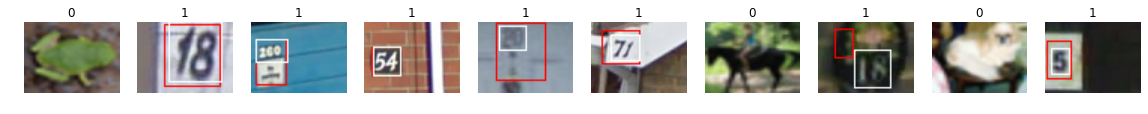

In [11]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

temp_labels = valid_labels
temp_data = valid_dataset

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i,j in enumerate(np.sort(np.random.randint(0, temp_labels.shape[0], size = 10))):
    im_samples.append(j)
    im = Image.fromarray(np.uint8(valid_dataset[j,:,:,:]))
    
    if val_predictions[j,1]>=0.5:
        draw = ImageDraw.Draw(im)
        draw.rectangle([val_predictions[j,3], val_predictions[j,2], \
                        val_predictions[j,5], val_predictions[j,4]], fill=None, outline=(255,0,0))
        
        draw.rectangle([temp_labels[j,2], temp_labels[j,1], \
                        temp_labels[j,4], temp_labels[j,3]], fill=None, outline=(255,255,255))
    
    ax[i].axis('off')
    label = temp_labels[j,0]
    ax[i].set_title(label, loc='center')
    ax[i].imshow(im)
